In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import DateFormatter, AutoDateLocator


url_fr = "https://disease.sh/v3/covid-19/historical/France?lastdays=all"
url_it = "https://disease.sh/v3/covid-19/historical/Italy?lastdays=all"

resp_fr = requests.get(url_fr)
resp_it = requests.get(url_it)

resp_fr.raise_for_status()
resp_it.raise_for_status()

data_fr_js = resp_fr.json()
data_it_js = resp_it.json()

data_it = pd.DataFrame(data_it_js["timeline"])
data_fr = pd.DataFrame(data_fr_js["timeline"])


In [3]:
print(data_fr.isnull().values.any()) 
print(data_it.isnull().values.any()) 

False
False


In [4]:
print(data_it.index.duplicated().sum())
print(data_fr.index.duplicated().sum())
#stampa il numero di volte in cui una data è ripetuta

0
0


By performing a general analysis of the dataset using the describe command, we encountered an issue. Specifically, for the "recovered" variable in both France and Italy, the median is significantly different from the mean. In particular, the value of zero for a cumulative variable—such as the number of recovered individuals—does not make logical sense. Further investigation of the dataset revealed the presence of null values. After 08/05/2021, the recovered data for both countries consist only of zeros.

In [6]:
print(data_it.describe()) 
print(data_fr.describe())

              cases         deaths     recovered
count  1.143000e+03    1143.000000  1.143000e+03
mean   8.821664e+06  111930.694663  6.642502e+05
std    9.064593e+06   59672.484414  1.257262e+06
min    0.000000e+00       0.000000  0.000000e+00
25%    7.457085e+05   39235.500000  0.000000e+00
50%    4.440669e+06  128432.000000  0.000000e+00
75%    1.736443e+07  166509.000000  2.606320e+05
max    2.560351e+07  188322.000000  4.144608e+06
              cases         deaths      recovered
count  1.143000e+03    1143.000000    1143.000000
mean   1.409091e+07   99221.659668   84432.664917
std    1.470445e+07   53297.832483  128282.286212
min    0.000000e+00       0.000000       0.000000
25%    1.579906e+06   38108.500000       0.000000
50%    6.543481e+06  112925.000000       0.000000
75%    2.964361e+07  149168.000000  113149.000000
max    3.986672e+07  166176.000000  415111.000000


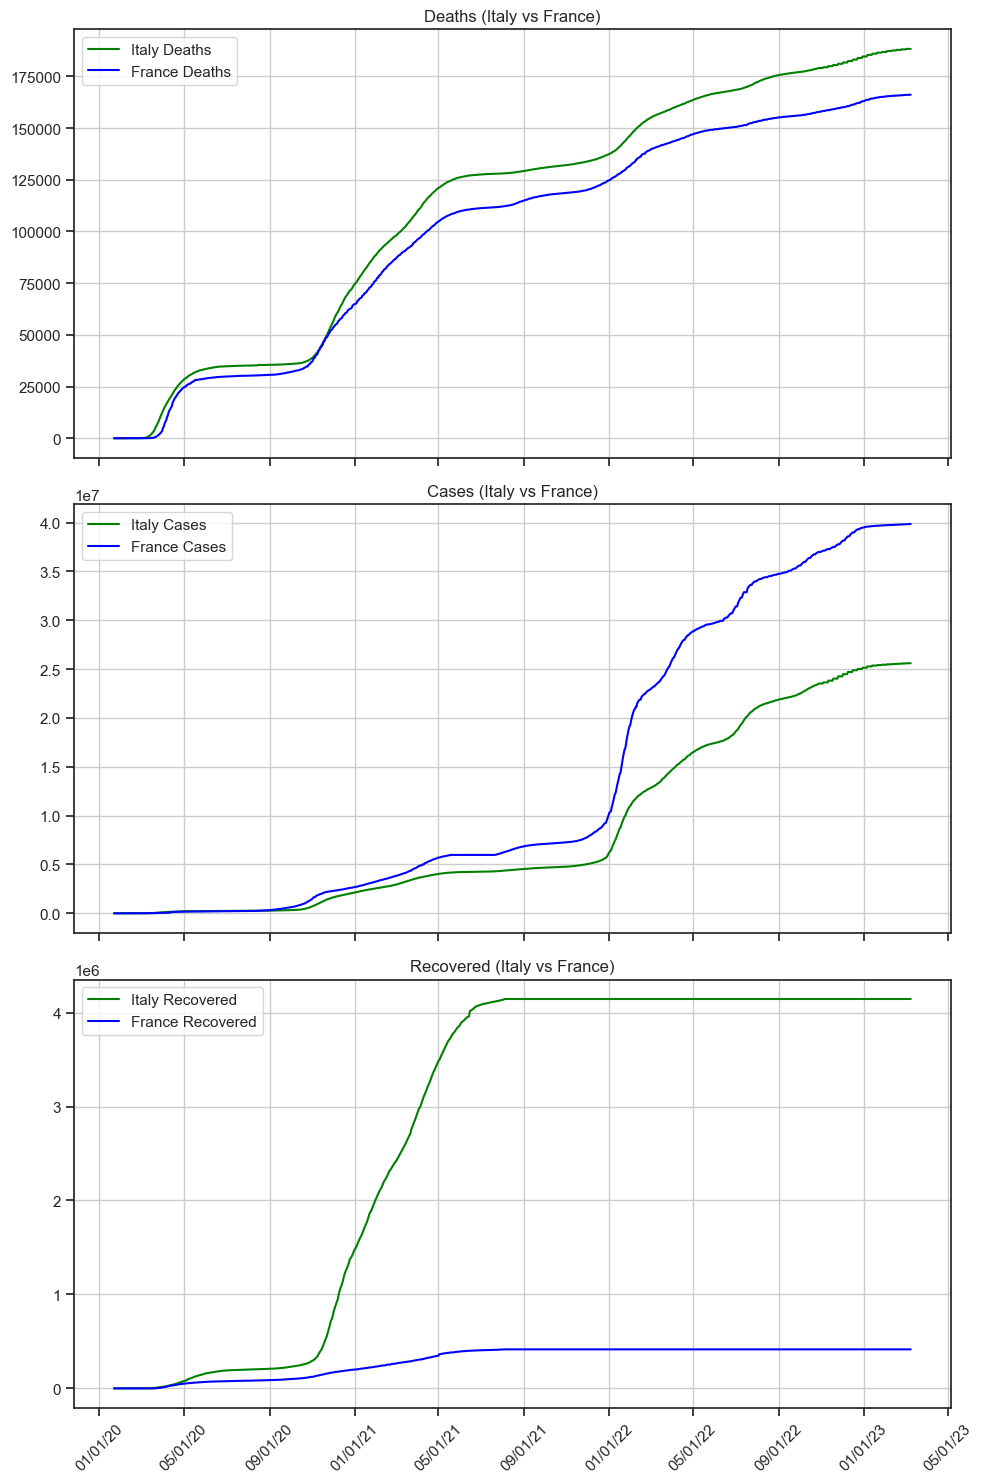

In [35]:
data_fr.index = pd.to_datetime(data_fr.index, format="%m/%d/%y")
data_it.index = pd.to_datetime(data_it.index, format="%m/%d/%y")

# Creare il grafico per i dati di Italia e Francia
fig, axes = plt.subplots(3, 1, figsize=(10, 15), sharex=True)

# Formattazione dell'asse x
date_locator = AutoDateLocator()
date_formatter = DateFormatter("%m/%d/%y")

# Dati di decessi (Italia vs Francia)
axes[0].plot(data_it.index, data_it["deaths"], label="Italy Deaths", color="green")
axes[0].plot(data_fr.index, data_fr["deaths"], label="France Deaths", color="blue")
axes[0].set_title("Deaths (Italy vs France)")
axes[0].legend()

# Dati di casi (Italia vs Francia)
axes[1].plot(data_it.index, data_it["cases"], label="Italy Cases", color="green")
axes[1].plot(data_fr.index, data_fr["cases"], label="France Cases", color="blue")
axes[1].set_title("Cases (Italy vs France)")
axes[1].legend()

# Dati di guarigioni (Italia vs Francia)
axes[2].plot(data_it.index, data_it["recovered"], label="Italy Recovered", color="green")
axes[2].plot(data_fr.index, data_fr["recovered"], label="France Recovered", color="blue")
axes[2].set_title("Recovered (Italy vs France)")
axes[2].legend()

# Configurare l'asse x per tutti i subplot
for ax in axes:
    ax.xaxis.set_major_locator(date_locator)
    ax.xaxis.set_major_formatter(date_formatter)
    ax.grid(True)

plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per renderle leggibili
plt.tight_layout()
plt.show()

In [8]:
zero_recovered_it = data_it[(data_it["recovered"] == 0) & (data_it.index > "31-05-2021")].index.min()
zero_recovered_fr = data_fr[(data_it["recovered"] == 0) & (data_fr.index > "31-05-2021")].index.min()

print(zero_recovered_it)
print(zero_recovered_fr)

2021-08-05 00:00:00
2021-08-05 00:00:00


Let's focus on analyzing the values up to 08/05/2021.

In [10]:
cutoff_date = "7/5/21"
data_fr_cut = data_fr[data_fr.index <= cutoff_date]
data_it_cut = data_it[data_it.index <= cutoff_date]

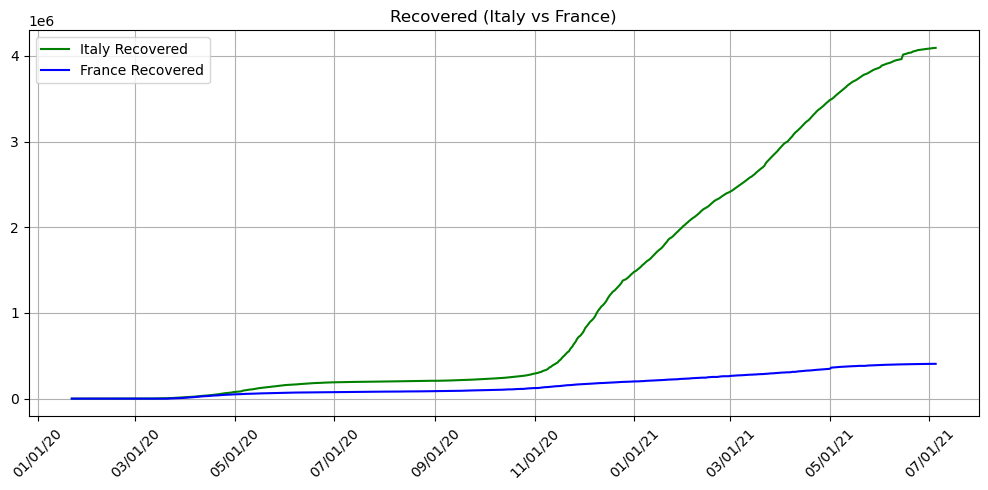

In [11]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(data_it_cut.index, data_it_cut["recovered"], label="Italy Recovered", color="green")
ax.plot(data_fr_cut.index, data_fr_cut["recovered"], label="France Recovered", color="blue")
ax.set_title("Recovered (Italy vs France)")
ax.legend()

# Configurare l'asse x
ax.xaxis.set_major_locator(date_locator)
ax.xaxis.set_major_formatter(date_formatter)
ax.grid(True)

plt.xticks(rotation=45)  # Ruota le etichette dell'asse x per renderle leggibili
plt.tight_layout()
plt.show()

The three variables used above are cumulative. We use the `.diff` command to observe the daily trend of the values.

In [13]:
anomalous_days_it = data_it[data_it["deaths"] > data_it["cases"]]
print(anomalous_days_it[["deaths", "cases"]])
anomalous_days_fr = data_fr[data_fr["deaths"] > data_fr["cases"]]
print(anomalous_days_fr[["deaths", "cases"]])

Empty DataFrame
Columns: [deaths, cases]
Index: []
Empty DataFrame
Columns: [deaths, cases]
Index: []


In [14]:
anomalous_days_it = data_it[data_it["recovered"] > data_it["cases"]]
print(anomalous_days_it[["recovered", "cases"]])
anomalous_days_fr = data_fr[data_fr["recovered"] > data_fr["cases"]]
print(anomalous_days_fr[["recovered", "cases"]])

Empty DataFrame
Columns: [recovered, cases]
Index: []
Empty DataFrame
Columns: [recovered, cases]
Index: []


In [15]:
# here substitute recovered data only before 
#here we go through each observation for each data set 
def substitute_missing(df, column_name):
    dates_errors = []
    for i in range(1, len(df)):
        if df.loc[df.index[i], column_name] < df.loc[df.index[i-1], column_name]:
            df.loc[df.index[i], column_name] = df.loc[df.index[i-1], column_name]
            dates_errors.append(i)
    return df[column_name] , dates_errors


data_it["cases"], mistakes_cases_it  = substitute_missing(data_it, "cases")
data_it["deaths"], mistakes_death_it  = substitute_missing(data_it, "deaths")
data_it_cut["recovered"], mistakes_recovered_it  = substitute_missing(data_it, "recovered")

data_fr["cases"], mistakes_cases_fr  = substitute_missing(data_fr, "cases")
data_fr["deaths"], mistakes_death_fr  = substitute_missing(data_fr, "deaths") 
data_fr_cut["recovered"], mistakes_recovered_fr =  substitute_missing(data_fr, "recovered")

mistakes_cases_it, mistakes_death_it, mistakes_cases_fr , mistakes_death_fr 

/var/folders/lc/lp9xh6t56wd0vdhf5m8kbjkw0000gn/T/ipykernel_77529/4271521421.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_it_cut["recovered"], mistakes_recovered_it  = substitute_missing(data_it, "recovered")
/var/folders/lc/lp9xh6t56wd0vdhf5m8kbjkw0000gn/T/ipykernel_77529/4271521421.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_fr_cut["recovered"], mistakes_recovered_fr =  substitute_missing(data_fr, "recovered")


([149],
 [154],
 [73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  92,
  98,
  99,
  123,
  124,
  132,
  133,
  158,
  287,
  484,
  485,
  486,
  487,
  488,
  489,
  490,
  491,
  492,
  493,
  494,
  495,
  496,
  497,
  498,
  499,
  500,
  501,
  502,
  503,
  504,
  505,
  506,
  507,
  508,
  509,
  510,
  511,
  512,
  513,
  514,
  515,
  516,
  517,
  518,
  519,
  520,
  521,
  522,
  523,
  524,
  525,
  526,
  527,
  528,
  529,
  530,
  531,
  532,
  533,
  534,
  535,
  536,
  537,
  538,
  539,
  540,
  541,
  542,
  543,
  544,
  545,
  546,
  852,
  871,
  872,
  873],
 [118, 119, 120, 123, 165, 181, 182, 226, 227, 228, 277, 287, 1099])

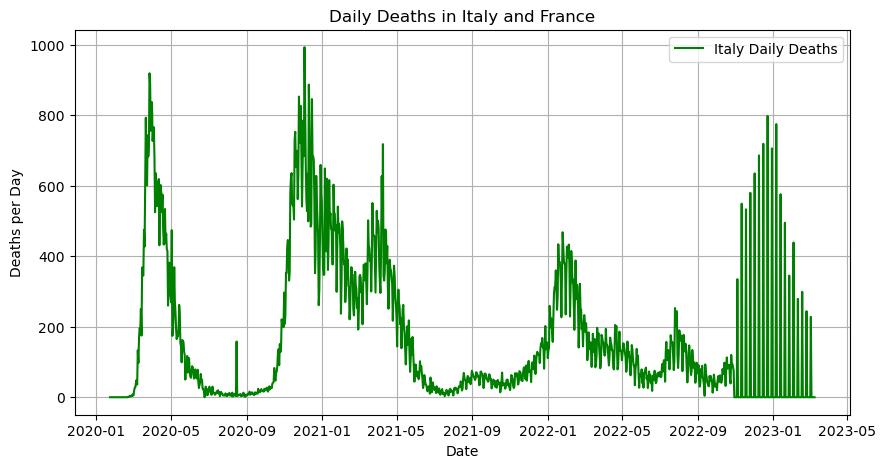

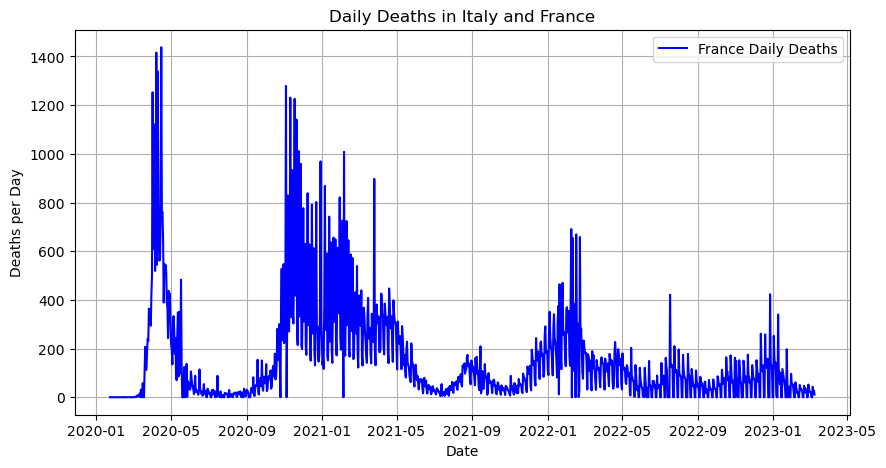

In [16]:
data_it["daily_deaths"] = data_it["deaths"].diff()
data_fr["daily_deaths"] = data_fr["deaths"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["daily_deaths"], label="Italy Daily Deaths", color="green")
plt.title("Daily Deaths in Italy and France")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["daily_deaths"], label="France Daily Deaths", color="blue")
plt.title("Daily Deaths in Italy and France")
plt.xlabel("Date")
plt.ylabel("Deaths per Day")
plt.legend()
plt.grid()
plt.show()

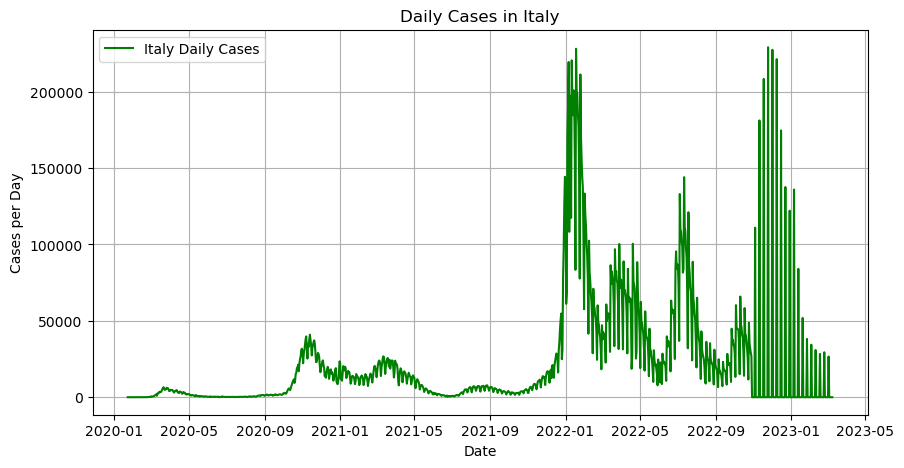

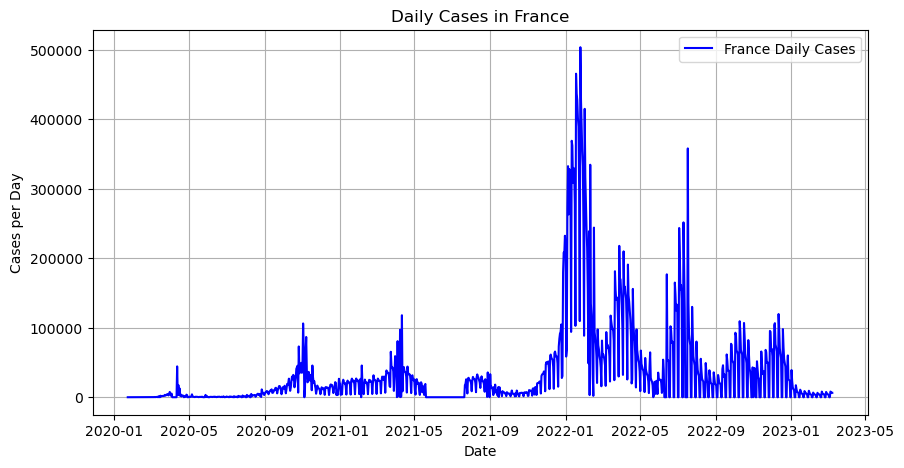

In [17]:
data_it["daily_cases"] = data_it["cases"].diff()
data_fr["daily_cases"] = data_fr["cases"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["daily_cases"], label="Italy Daily Cases", color="green")
plt.title("Daily Cases in Italy")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["daily_cases"], label="France Daily Cases", color="blue")
plt.title("Daily Cases in France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

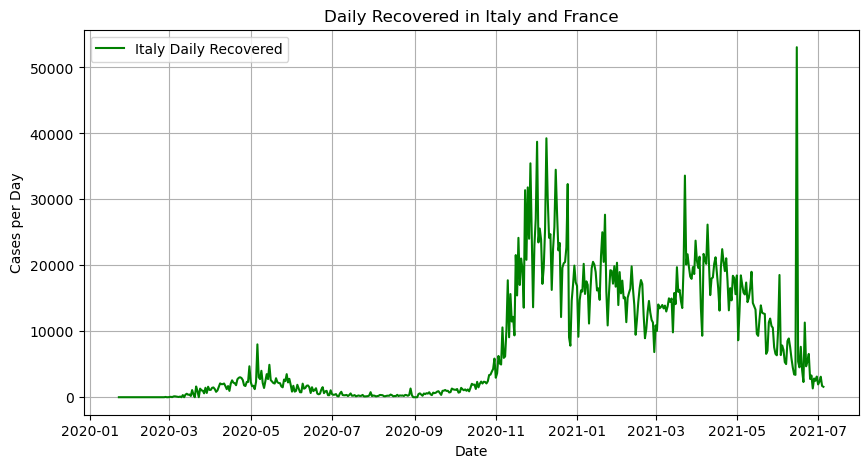

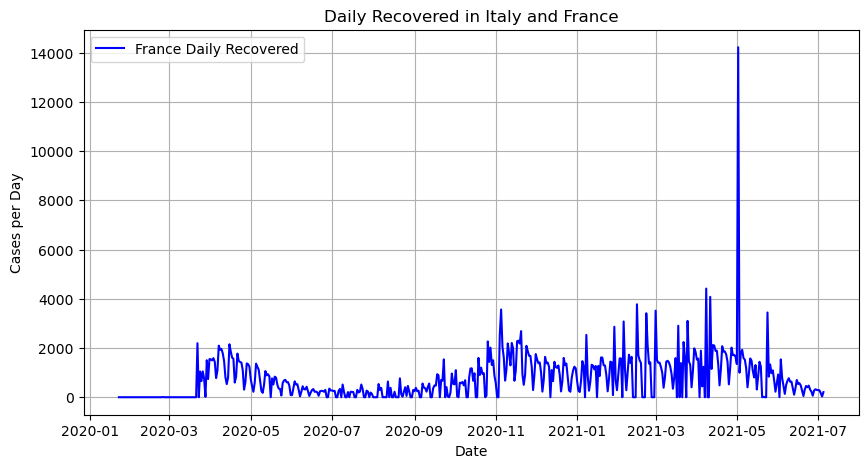

In [18]:
data_it_cut = data_it_cut.copy()
data_it_cut["daily_recovered"] = data_it_cut["recovered"].diff()
data_fr_cut = data_fr_cut.copy()
data_fr_cut["daily_recovered"] = data_fr_cut["recovered"].diff()

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["daily_recovered"], label="Italy Daily Recovered", color="green")
plt.title("Daily Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr_cut.index, data_fr_cut["daily_recovered"], label="France Daily Recovered", color="blue")
plt.title("Daily Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Day")
plt.legend()
plt.grid()
plt.show()

Let's now focus on analyzing the weekly data.

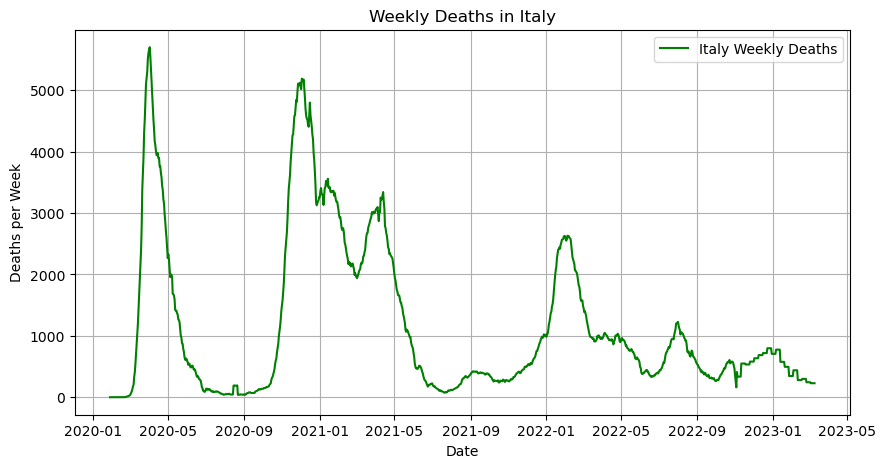

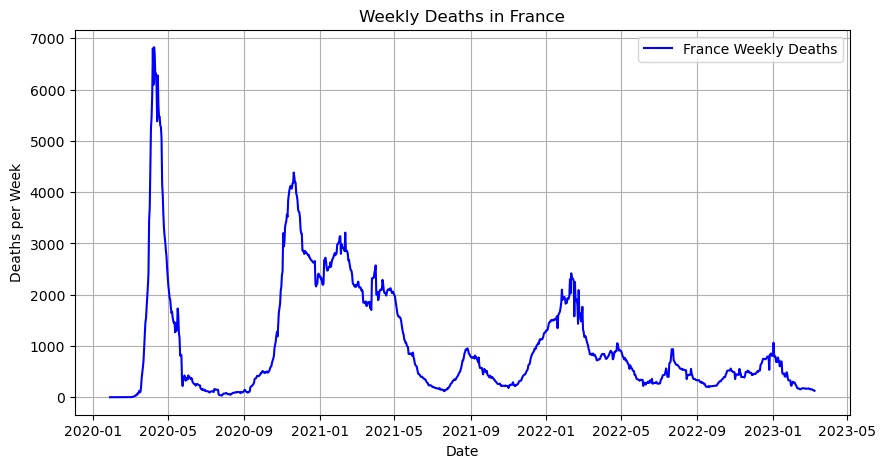

In [20]:
data_it = data_it.copy()
data_it.loc[:, "weekly_deaths"] = data_it["deaths"].diff(periods=7)
data_fr = data_fr.copy()
data_fr.loc[:, "weekly_deaths"] = data_fr["deaths"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["weekly_deaths"], label="Italy Weekly Deaths", color="green")
plt.title("Weekly Deaths in Italy")
plt.xlabel("Date")
plt.ylabel("Deaths per Week")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["weekly_deaths"], label="France Weekly Deaths", color="blue")
plt.title("Weekly Deaths in France")
plt.xlabel("Date")
plt.ylabel("Deaths per Week")
plt.legend()
plt.grid()
plt.show()

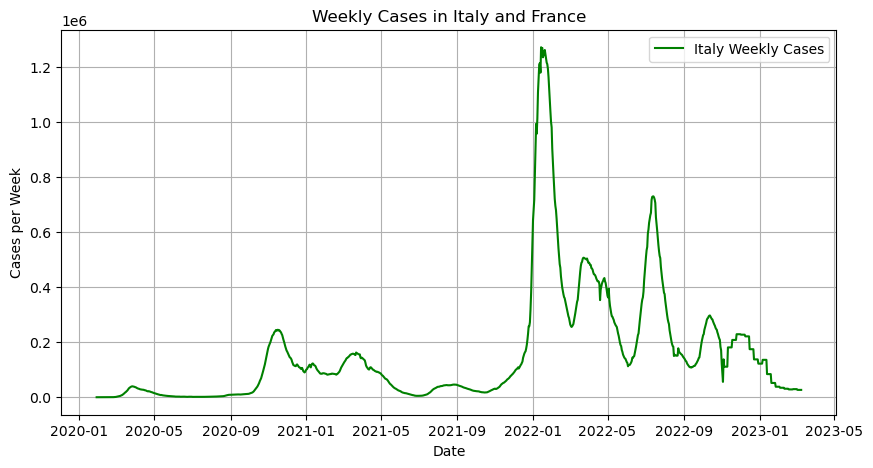

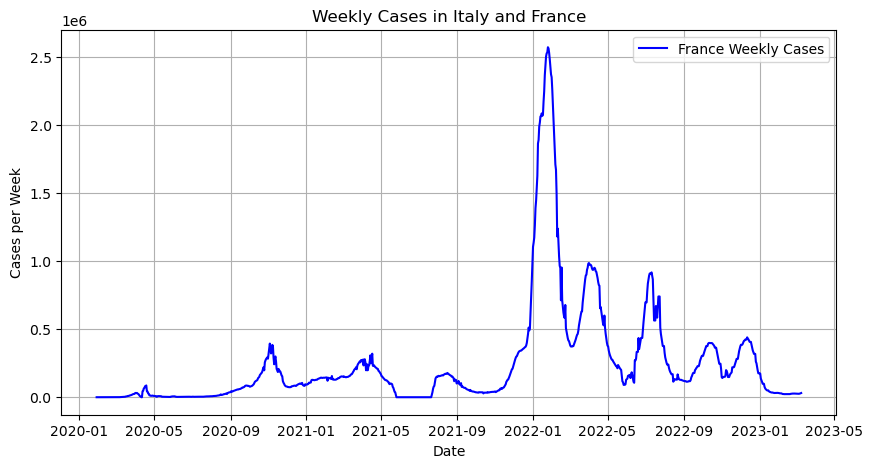

In [21]:
data_it["weekly_cases"] = data_it["cases"].diff(periods=7)
data_fr["weekly_cases"] = data_fr["cases"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it.index, data_it["weekly_cases"], label="Italy Weekly Cases", color="green")
plt.title("Weekly Cases in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr.index, data_fr["weekly_cases"], label="France Weekly Cases", color="blue")
plt.title("Weekly Cases in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

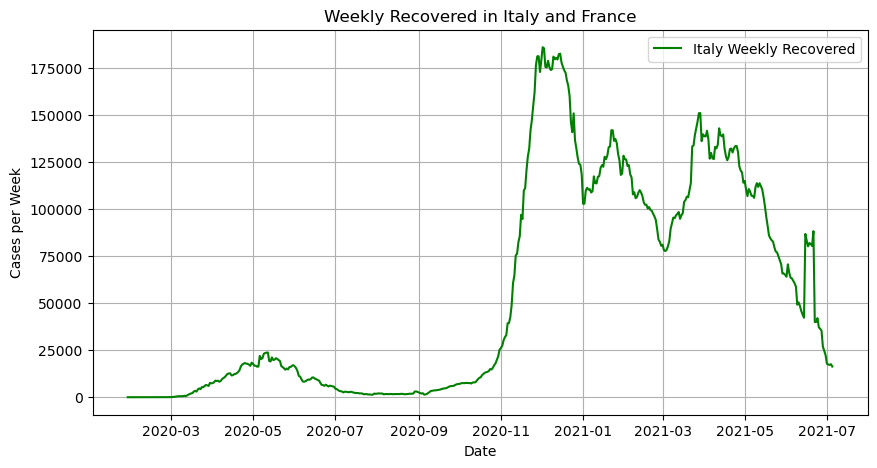

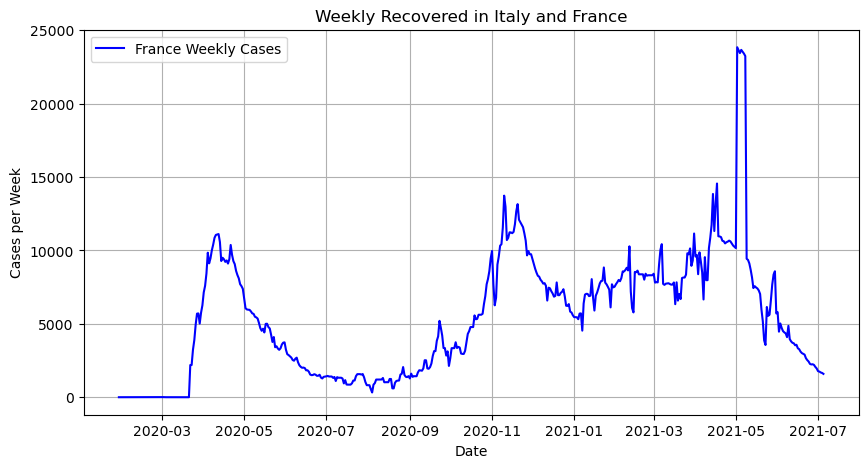

In [22]:
data_it_cut = data_it_cut.copy()
data_fr_cut = data_fr_cut.copy()
data_it_cut["weekly_recovered"] = data_it_cut["recovered"].diff(periods=7)
data_fr_cut["weekly_recovered"] = data_fr_cut["recovered"].diff(periods=7)

plt.figure(figsize=(10, 5))
plt.plot(data_it_cut.index, data_it_cut["weekly_recovered"], label="Italy Weekly Recovered", color="green")
plt.title("Weekly Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(data_fr_cut.index, data_fr_cut["weekly_recovered"], label="France Weekly Cases", color="blue")
plt.title("Weekly Recovered in Italy and France")
plt.xlabel("Date")
plt.ylabel("Cases per Week")
plt.legend()
plt.grid()
plt.show()

It can be observed that the graphs exhibit similar patterns. Special attention can be given to the "cases"-"recovered" ratio, as the latter represents the first shift by a few weeks. This can be explained by recalling that the time between becoming positive and recovering (returning to negative) typically takes a few weeks.


In general, the behaviors between France and Italy are comparable, except for the "recovered" variable.

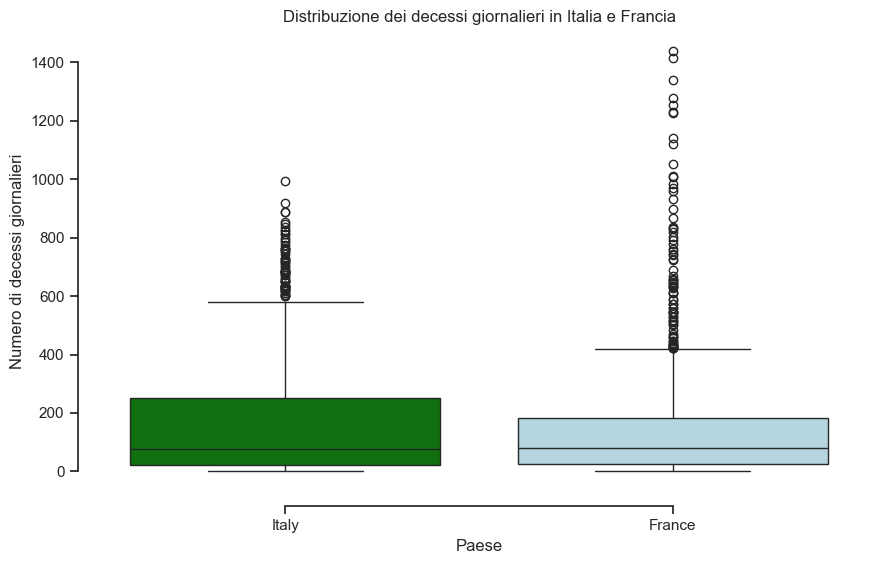

In [25]:
sns.set_theme(style="ticks", palette="pastel")
df = pd.DataFrame({
    "deaths": pd.concat([data_it["daily_deaths"], data_fr["daily_deaths"]], ignore_index=True),
    "country": ["Italy"] * len(data_it) + ["France"] * len(data_fr)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="country", y="deaths", data=df, palette=["green", "lightblue"], hue="country")

# Miglioriamo l'aspetto del grafico
sns.despine(offset=10, trim=True)
plt.title("Boxpolots of Daily Deaths in Italy and France")
plt.xlabel("Country")
plt.ylabel("Number of Daily Deaths")

# Mostriamo il grafico
plt.show()

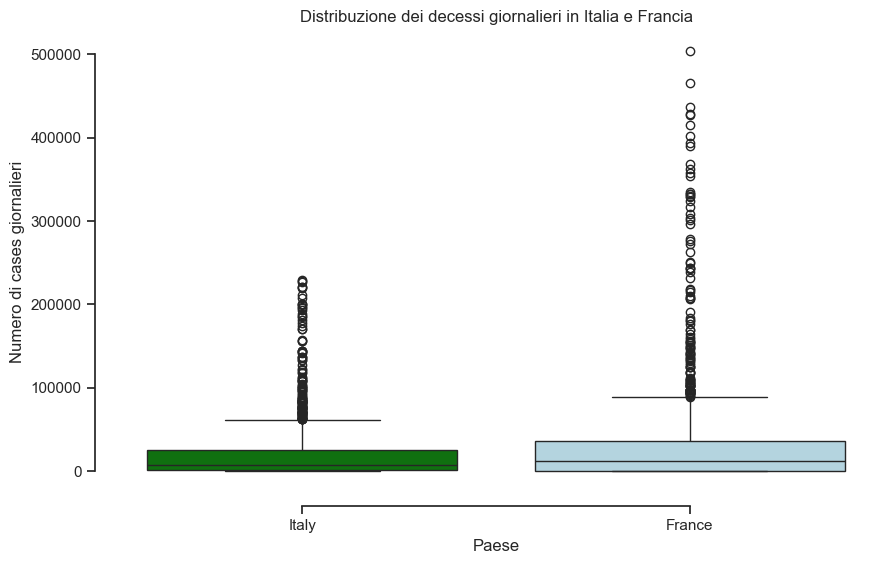

In [26]:
sns.set_theme(style="ticks", palette="pastel")
df = pd.DataFrame({
    "cases": pd.concat([data_it["daily_cases"], data_fr["daily_cases"]], ignore_index=True),
    "country": ["Italy"] * len(data_it) + ["France"] * len(data_fr)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="country", y="cases", data=df, palette=["green", "lightblue"], hue="country")

# Miglioriamo l'aspetto del grafico
sns.despine(offset=10, trim=True)
plt.title("Boxpolots of Daily Cases in Italy and France")
plt.xlabel("Country")
plt.ylabel("Number of Daily Cases")

# Mostriamo il grafico
plt.show()

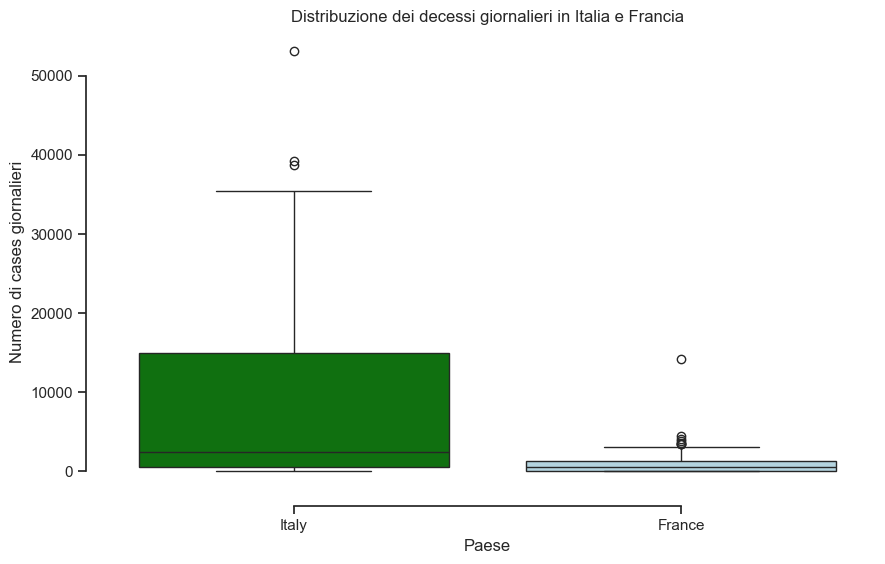

In [28]:
sns.set_theme(style="ticks", palette="pastel")
df = pd.DataFrame({
    "recovered": pd.concat([data_it_cut["daily_recovered"], data_fr_cut["daily_recovered"]], ignore_index=True),
    "country": ["Italy"] * len(data_it_cut) + ["France"] * len(data_fr_cut)
})

plt.figure(figsize=(10, 6))
sns.boxplot(x="country", y="recovered", data=df, palette=["green", "lightblue"], hue="country")

# Miglioriamo l'aspetto del grafico
sns.despine(offset=10, trim=True)
plt.title("Boxpolots of Daily Recovered in Italy and France")
plt.xlabel("Country")
plt.ylabel("Number of Daily Recovered")

# Mostriamo il grafico
plt.show()

we use the cut data set for recovereds 